# Balancing Oliveira

The objective of this notebook is to explore the viability of conducting dataset sample balancing through two techniques:

1. Resampling (specifically RandomOverSampler)
2. SMOTE (specifically SMOTEN)

It turns out, there is a dedicated library called "[Imbalanced Learn"](https://imbalanced-learn.org/stable/index.html) (denoted as `imblearn`) which can be used to handle imbalanced datasets such that it can perform the two techniques.

**It is assumed (unless otherwise stated) that other data pre-processing (i.e., removing duplicates, data cleaning, label encoding, and shuffling/renaming of columns) will be done after this. Hence, this notebook only explores time-based behaviors (i.e., with duplicates).**

This notebook will also look into implementing/testing the proposal of Tustin where she suggested to use part of Oliveira for Model Robustness Testing instead of a third-party dataset as originally proposed. The overview of its steps are as follows:

1. Get the raw dataset (Oliveira).
2. Split it into train (70%) and test (30%)
3. The train split will undergo smote/resampling.
4. Then the test split will be used to determine if the model really works well and robustly

*Note that the hyperparameter `random_state` was set to `1` instead of `None` for test repeatability.*

In [1]:
import time
start_time = 0
def start():
    global start_time
    start_time = time.time()
def end():
    print("Elapsed time:", time.time()-start_time, "seconds")

from sklearn.ensemble import HistGradientBoostingClassifier #Nearest to LightGBM and XGBoost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def hgbt_classifier(dataset, cat):
    X = dataset.iloc[:,1:101]
    y = dataset.iloc[:,101]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
    hgbt = HistGradientBoostingClassifier(loss='log_loss', learning_rate=0.1, max_iter=300, max_leaf_nodes=2, 
                                        max_depth=None, min_samples_leaf=20, l2_regularization=0.0, max_bins=255, 
                                        categorical_features=cat, monotonic_cst=None, interaction_cst=None, 
                                        warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, 
                                        n_iter_no_change=10, tol=1e-07, verbose=0, random_state=1, class_weight=None)
    start()
    hgbt.fit(X_train, y_train)
    end()
    y_pred = hgbt.predict(X_test)
    print(classification_report(y_test, y_pred, digits=4))

# Import Dataset

In [2]:
import pandas as pd

start()
oli = pd.read_csv("oliveira.csv")
end()
print(oli.shape)
oli.head()

Elapsed time: 0.451235294342041 seconds
(43876, 102)


,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,1
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,208,302,208,302,187,208,302,228,302,1
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,40,209,260,141,260,141,260,1


# Check Labels

In [3]:
oli["malware"].value_counts()

malware
1    42797
0     1079
Name: count, dtype: int64

# Obtain Features (X)

This includes the hash as part *feature* for now. 

However, for model training/fitting, the hash will not be considered as a feature anymore. 

In [4]:
X = oli.iloc[:,:101]
X.head()

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,117,71,297,135,171,215,35,208,56,71
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,60,81,240,117,71,297,135,171,215,35
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,123,65,112,123,65,112,123,65,113,112
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,215,208,302,208,302,187,208,302,228,302
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,40,209,260,40,209,260,141,260,141,260


# Obtain Labels (y)

In [5]:
#Obtain labels y
y = oli.iloc[:,101]
y.head()

0    1
1    1
2    1
3    1
4    1
Name: malware, dtype: int64

# Baseline Performance

In [6]:
hgbt_classifier(oli, None)

Elapsed time: 1.8992679119110107 seconds
              precision    recall  f1-score   support

           0     0.8963    0.4468    0.5963       329
           1     0.9860    0.9987    0.9923     12834

    accuracy                         0.9849     13163
   macro avg     0.9412    0.7227    0.7943     13163
weighted avg     0.9838    0.9849    0.9824     13163



# 1. Oversampling

For this, imblearn's RandomOverSampler will be used as a resampling technique.

Further details can be found [here](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html).

In [7]:
from imblearn.over_sampling import RandomOverSampler

start()
ros = RandomOverSampler(random_state=1, sampling_strategy='minority') #random_state is arbitrary; setting a value makes its output repeatable
X_resampled, y_resampled = ros.fit_resample(X, y) #Resampling of minority classes (i.e., Benign/0 for Oliveira)
end()

oli_resampled = pd.concat([X_resampled,y_resampled.copy()], axis=1)
print("X_resampled:", X_resampled.shape)
print("y_resampled:", y_resampled.shape)
print("Oliveira (Resampled):", oli_resampled.shape, "\n")
print("Class Count:\n" + str(oli_resampled['malware'].value_counts()), "\n")
print("Top 20 Most Repeated Samples:\n" + str(oli_resampled[['hash','malware']].value_counts()[0:20]), "\n")
print("Unique Values:", len(oli_resampled['hash'].unique()))
oli_resampled

Elapsed time: 0.8354144096374512 seconds
X_resampled: (85594, 101)
y_resampled: (85594,)
Oliveira (Resampled): (85594, 102) 

Class Count:
malware
1    42797
0    42797
Name: count, dtype: int64 

Top 20 Most Repeated Samples:
hash                              malware
03384ab6368b68ed16ecb9e6352539af  0          90
0822ec2ba98d291e5bfc836bc3686096  0          90
f78ea80cec007b2c32fb10f9c6c82f39  0          88
075323e77815ee8bcc7854ce23955a15  0          79
79b78bb3d583748040c41ded09555fd3  0          72
bdaaac3fa3f6796825a51ef1c0e5b3fd  0          71
3d8a7a97ea954dd4fe66279df2b445e0  0          70
d0b42a077320d2ab2d2a80bcbcae02cb  0          60
3daa3068ea8bf5d2e65820c42af62227  0          59
7cc90abc007d2efc476930137899cfda  0          58
484b5a0e5782535e1091412d24198afc  0          58
0566db6153dc8f7bdbef9552a6852139  0          57
9976cd22e18868887eacb927616d5e41  0          57
3a056dfba8365bc058ac05634cb22818  0          56
74db62f95ab558326cc79e4001726832  0          56
c6f4acf3988

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,1
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,208,302,208,302,187,208,302,228,302,1
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,40,209,260,141,260,141,260,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85589,e1efa1385daabfec74fe877f63f7daf1,286,110,172,240,117,240,117,240,117,...,215,114,215,117,71,25,71,275,260,0
85590,892262603e040080d04a9e5f72e3165b,82,228,16,215,89,208,215,274,158,...,194,82,194,297,194,297,194,82,194,0
85591,0b2a5e7d55bc9ca38c5c736d85b1195f,82,172,117,16,172,117,172,117,198,...,187,215,73,29,73,29,82,240,117,0
85592,1206af04cdc528613fc12471419ebf01,16,172,194,274,158,215,274,158,215,...,158,215,274,158,215,274,158,215,274,0


The data above (`Top 20 Most Repeated Samples`) suggests that the samples that were duplicated in RandomOverSampler were relatively balanced.

Consider the Computation:

| Computation                       | Value |
|-----------------------------------|-------|
| Initial Benign   Samples          | 1079  |
| Benign Samples after Resampling   | 42797 |
| Diff. Before and After Resampling | 41718 |	
		
Distribution of Top 5 Most Resampled Sample:

| Sample                           | Quantity in Resampled | % in Resampled |
|----------------------------------|-----------------------|----------------|
| 03384ab6368b68ed16ecb9e6352539af | 90                    | 0.22%          |
| 0822ec2ba98d291e5bfc836bc3686096 | 90                    | 0.22%          |
| f78ea80cec007b2c32fb10f9c6c82f39 | 88                    | 0.21%          |
| 075323e77815ee8bcc7854ce23955a15 | 79                    | 0.19%          |
| 79b78bb3d583748040c41ded09555fd3 | 72                    | 0.17%          |

In [8]:
hgbt_classifier(oli_resampled, None)

Elapsed time: 4.138524293899536 seconds
              precision    recall  f1-score   support

           0     0.9110    0.8571    0.8832     12827
           1     0.8653    0.9164    0.8901     12852

    accuracy                         0.8868     25679
   macro avg     0.8882    0.8868    0.8867     25679
weighted avg     0.8881    0.8868    0.8867     25679



# 2. SMOTE (specifically SMOTEN)

For this, imblearn's SMOTEN will be used as the SMOTE technique. SMOTEN (Synthetic Minority Over-sampling Technique for Nominal) which is described as 

`This method is referred as SMOTEN in [1]. It expects that the data to resample are only made of categorical features.`

Further details can be found [here](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTEN.html).

For this example, it is assumed that the numerical values will act as in-place of categorical data since HGBT does not support categorical data. Apart from that, the hashes are considered still as categorical data despite its irrelevance in the training and prediction process.

In [9]:
from imblearn.over_sampling import SMOTEN

start()
smoten = SMOTEN(random_state=1, sampling_strategy='minority') #random_state is arbitrary; setting a value makes its output repeatable
X_smoten, y_smoten = smoten.fit_resample(X, y) #Resampling of minority classes (i.e., Benign/0 for Oliveira)
end()

oli_smoten = pd.concat([X_smoten,y_smoten.copy()], axis=1)
print("X_smoten", X_smoten.shape)
print("y_smoten", y_smoten.shape)
print("Oliveira (SMOTEN):", oli_smoten.shape, "\n")
print("Class Count:\n" + str(oli_smoten['malware'].value_counts()), "\n")
print("Top 10 Most Repeated Samples:\n" + str(oli_smoten[['hash','malware']].value_counts()[0:20]),"\n")
print("Unique Values:", len(oli_smoten['hash'].unique()))
oli_smoten

Elapsed time: 401.6305932998657 seconds
X_smoten (85594, 101)
y_smoten (85594,)
Oliveira (SMOTEN): (85594, 102) 

Class Count:
malware
1    42797
0    42797
Name: count, dtype: int64 

Top 10 Most Repeated Samples:
hash                              malware
3cedd98ea184c22ee3b024c72a96e075  0          5965
0fbe9eac4ff5af1a392d92881c70c559  0          3728
0b7e7bc7598abe9cfdc594e17e795cf0  0          1895
125d4cdb14dbe86841037e5bbfc6a0bc  0           895
35dd2f5d51ba224735732424f8ab6398  0           860
05d2a956ac82d30fef9b807e9746b339  0           833
0d77f98fafb6c34a5861e61de06b4b0f  0           718
0d2ab02c993ea29a1989b442bf7150c7  0           622
06b43cb00b61be55b6d100b15edfbc39  0           568
07613e49400add94324002a019d3a9f5  0           566
0bdf4fee812ba46472f51d1ae2ef5e04  0           554
0822ec2ba98d291e5bfc836bc3686096  0           529
3506356c329758e4f703cd2103d7daab  0           505
501e961feebbde040fb836cb5de122c2  0           498
0fca2620b9f96936b7594fc650b1d8ca  0        

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,1
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,208,302,208,302,187,208,302,228,302,1
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,40,209,260,141,260,141,260,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85589,0fbe9eac4ff5af1a392d92881c70c559,286,110,172,240,117,240,117,240,117,...,215,114,215,117,71,25,71,275,260,0
85590,0d77f98fafb6c34a5861e61de06b4b0f,82,172,16,274,158,215,117,158,215,...,117,215,274,158,215,274,158,215,274,0
85591,0b2a5e7d55bc9ca38c5c736d85b1195f,82,208,117,208,172,117,172,208,16,...,31,117,73,215,73,29,82,117,85,0
85592,0d77f98fafb6c34a5861e61de06b4b0f,82,172,16,274,158,215,274,158,215,...,158,215,274,158,215,274,158,215,274,0


The data above (`Top 20 Most Repeated Samples`) suggests that the samples that were duplicated in SMOTEN were skewed on a number of specific samples.

Consider the Computation:

| Computation                       | Value |
|-----------------------------------|-------|
| Initial Benign   Samples          | 1079  |
| Benign Samples after Resampling   | 42797 |
| Diff. Before and After Resampling | 41718 |	
		
Distribution of Top 5 Most Resampled Sample:

| Sample                           | Quantity in Resampled | % in Resampled |
|----------------------------------|-----------------------|----------------|
| 3cedd98ea184c22ee3b024c72a96e075 | 5965                  | 14.30%         |
| 0fbe9eac4ff5af1a392d92881c70c559 | 3728                  | 8.94%          |
| 0b7e7bc7598abe9cfdc594e17e795cf0 | 1895                  | 4.54%          |
| 125d4cdb14dbe86841037e5bbfc6a0bc | 895                   | 2.15%          |
| 35dd2f5d51ba224735732424f8ab6398 | 860                   | 2.06%          |

In [10]:
hgbt_classifier(oli_smoten,None)

Elapsed time: 2.912947654724121 seconds
              precision    recall  f1-score   support

           0     0.9374    0.9471    0.9423     12827
           1     0.9467    0.9369    0.9418     12852

    accuracy                         0.9420     25679
   macro avg     0.9421    0.9420    0.9420     25679
weighted avg     0.9421    0.9420    0.9420     25679



# 3. Proposed solution to allow for Model Robustness Testing

This implementation of the proposed solution assumes that the split will occur at data preparation.

Taking note of the overview of steps:

1. Get the raw dataset (Oliveira).
2. Split it into train (90%) and reserve (10%)
3. The train split will undergo SMOTE/resampling.
4. Then the test split will be used to determine if the model really works well and robustly

The Oliveira dataset will be divided into train and reserve splits at a 90:10 ratio. 

The train split will undergo balancing (either Resampling or SMOTE) while the test split will be as is.

The train split will be used in training where it will undergo further splitting as part of the cross-validation processes (i.e., holdout and repeated holdout) during training.

## 3.1. Loading Raw Oliveira

In [11]:
import time
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
import sklearn.model_selection as model_selection
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #For Confusion Matrix
import matplotlib.pyplot as plt #For figure plotting.

oli = pd.read_csv("oliveira.csv")
print(oli.shape)
oli.head()

(43876, 102)


,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,1
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,208,302,208,302,187,208,302,228,302,1
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,40,209,260,141,260,141,260,1


## 3.2. Splitting it into train and test at 90:10 ratio.
*Both will be logically named as train_split and reserve_split respectively.*

In [12]:
X = oli.iloc[:,0:101] #features
y = oli.iloc[:,101] #label

#Splitting to train_split and reserve_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)

#Building train_split dataframe.
train_split = pd.concat([X_train,y_train.copy()], axis=1)

#Building reserve_split dataframe.
reserve_split = pd.concat([X_test,y_test.copy()], axis=1)

In [13]:
print("train_split shape:", train_split.shape)
print("train_split value_counts:")
print(train_split['malware'].value_counts())
train_split.head()

train_split shape: (39488, 102)
train_split value_counts:
malware
1    38513
0      975
Name: count, dtype: int64


,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
21089,c666e239ce25f91048ced38ccfe24659,240,117,240,117,240,117,240,117,240,...,15,117,15,240,117,240,117,240,117,1
40618,96bd371670a23303d35dbe0a96f83d1e,215,274,158,215,274,158,215,172,117,...,81,60,81,172,117,25,172,117,172,1
7233,ea332897b590b8feca645d219d42838b,215,274,158,215,274,158,215,172,117,...,81,60,81,172,117,25,172,117,172,1
31038,97c015f5978914e256445fa84c7d6613,240,117,240,117,240,117,240,117,240,...,264,199,264,199,264,199,264,199,264,0
10082,4b795ce47b92f32bef67915ec79622ea,240,117,240,117,240,117,240,117,240,...,60,81,60,81,110,60,81,60,81,1


In [14]:
print("reserve_split shape:", reserve_split.shape)
print(reserve_split['malware'].value_counts())
reserve_split.head()

reserve_split shape: (4388, 102)
malware
1    4284
0     104
Name: count, dtype: int64


,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
24659,f0f8ba4c3d750a4ce2deea48152a33d4,215,274,158,215,274,158,215,172,117,...,117,15,240,117,240,117,240,117,172,1
34393,39b2d87c1adb582fbcacc3a56e274d48,286,110,172,240,117,240,117,240,117,...,71,275,260,240,117,141,65,260,141,1
20301,429236cdeb63d68bf48a3b48b0a34612,82,208,187,208,172,117,172,208,16,...,172,117,172,117,208,172,117,100,215,1
20025,46079cbf0bcfe8fab9894b4ec88bece3,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
19747,303ceda3f52afa9b69ed4f97fec2c895,82,240,117,240,117,240,117,240,117,...,82,260,141,260,141,260,141,260,141,1


## 3.3. Balancing train_split

*For this normal resampling will be selected as it is more 'balanced' than SMOTEN is.*

In [15]:
X = train_split.iloc[:,0:101]
y = train_split.iloc[:,101]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1) #For use in training and testing model
print("Labels:", y.unique())
print("Label Value Counts:\n" + str(y.value_counts()))

Labels: [1 0]
Label Value Counts:
malware
1    38513
0      975
Name: count, dtype: int64


In [16]:
ros = RandomOverSampler(random_state=1, sampling_strategy='minority') #random_state is arbitrary; setting a value makes its output repeatable
X_resampled, y_resampled = ros.fit_resample(X, y) #Resampling of minority classes (i.e., Benign/0 for Oliveira)

train_split = pd.concat([X_resampled,y_resampled.copy()], axis=1)
print("X_resampled", X_resampled.shape)
print("y_resampled", y_resampled.shape)
print("Oliveira (Resampling):", train_split.shape, "\n")
print("Class Count:\n" + str(train_split['malware'].value_counts()), "\n")
print("Top 10 Most Repeated Samples:\n" + str(train_split[['hash','malware']].value_counts()[0:20]),"\n")
print("Unique Values:", len(train_split['hash'].unique()))
train_split

X_resampled (77026, 101)
y_resampled (77026,)
Oliveira (Resampling): (77026, 102) 

Class Count:
malware
1    38513
0    38513
Name: count, dtype: int64 

Top 10 Most Repeated Samples:
hash                              malware
f78ea80cec007b2c32fb10f9c6c82f39  0          96
79b78bb3d583748040c41ded09555fd3  0          89
03384ab6368b68ed16ecb9e6352539af  0          84
bdaaac3fa3f6796825a51ef1c0e5b3fd  0          77
0822ec2ba98d291e5bfc836bc3686096  0          69
07613e49400add94324002a019d3a9f5  0          61
ed943067af3c2b31f9d56415a64029a5  0          60
29645842ce2b91fb7a5b1a9d54fab11f  0          59
1cefaf1484dbe5e7e8e8632f5531ca2d  0          59
5874e7cb83952938c85c9f74cc55e5c5  0          58
91415d7eb992b77410145dd5fe453d25  0          58
add6b18c844366b54a97e92549b3c0dc  0          57
b1d7807f1fdf9204b5f8e7d972c730b5  0          56
01ebb84c337b5e53b08603ab67b7f4b4  0          56
59b7280d73906b43b13b273a1f9cc3dd  0          56
125d4cdb14dbe86841037e5bbfc6a0bc  0          56
f2e6c

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,c666e239ce25f91048ced38ccfe24659,240,117,240,117,240,117,240,117,240,...,15,117,15,240,117,240,117,240,117,1
1,96bd371670a23303d35dbe0a96f83d1e,215,274,158,215,274,158,215,172,117,...,81,60,81,172,117,25,172,117,172,1
2,ea332897b590b8feca645d219d42838b,215,274,158,215,274,158,215,172,117,...,81,60,81,172,117,25,172,117,172,1
3,97c015f5978914e256445fa84c7d6613,240,117,240,117,240,117,240,117,240,...,264,199,264,199,264,199,264,199,264,0
4,4b795ce47b92f32bef67915ec79622ea,240,117,240,117,240,117,240,117,240,...,60,81,60,81,110,60,81,60,81,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77021,5fa9e22981f24c6648b49933ee1d3eee,286,110,172,240,117,240,117,240,117,...,215,114,215,117,261,106,144,297,117,0
77022,1ddddb36dcaf70112e870c4aed380bd3,286,110,172,240,117,240,117,240,117,...,215,114,215,117,261,106,144,297,71,0
77023,7cc90abc007d2efc476930137899cfda,286,110,172,240,117,240,117,240,117,...,215,114,215,117,71,25,71,275,260,0
77024,75996d059ad3724fc40d16b35a39851c,82,240,117,240,117,240,117,240,117,...,141,14,141,14,141,14,141,14,141,0


In [17]:
train_split.drop('hash', axis=1, inplace=True)
X = train_split.iloc[:,0:100]
y = train_split.iloc[:,100]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
train_split

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,240,117,240,117,240,117,240,117,240,117,...,15,117,15,240,117,240,117,240,117,1
1,215,274,158,215,274,158,215,172,117,172,...,81,60,81,172,117,25,172,117,172,1
2,215,274,158,215,274,158,215,172,117,172,...,81,60,81,172,117,25,172,117,172,1
3,240,117,240,117,240,117,240,117,240,117,...,264,199,264,199,264,199,264,199,264,0
4,240,117,240,117,240,117,240,117,240,117,...,60,81,60,81,110,60,81,60,81,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77021,286,110,172,240,117,240,117,240,117,106,...,215,114,215,117,261,106,144,297,117,0
77022,286,110,172,240,117,240,117,240,117,106,...,215,114,215,117,261,106,144,297,71,0
77023,286,110,172,240,117,240,117,240,117,106,...,215,114,215,117,71,25,71,275,260,0
77024,82,240,117,240,117,240,117,240,117,240,...,141,14,141,14,141,14,141,14,141,0


## 3.4. Training on Train_Split

*A simple HGBT with K-Cross CV for testing and tuning (RandomizedSearchCV) will be executed for this example.*

In [18]:
#All hyperparameters are defaults except for random_state
hgbt = HistGradientBoostingClassifier(loss='log_loss', learning_rate=0.1, max_iter=300, max_leaf_nodes=31, max_depth=None, 
            min_samples_leaf=20, l2_regularization=0.0, max_bins=255, categorical_features=None, 
            monotonic_cst=None, interaction_cst=None, warm_start=False, early_stopping='auto', scoring='loss', 
            validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=1, class_weight=None)

def kfolds(X,y,model):
    kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    sublist = [["accuracy", "f1_score","precision","recall","roc-auc","time"]]
    axis = 0
    for i, (train_index, test_index) in enumerate(kf.split(X,y)):
        print("Fold: " + str(i), end="") 
        start = time.time()
        training_set = np.take(X, train_index, axis)
        training_set_labels = np.take(y, train_index, axis)
        test_set = np.take(X, test_index, axis)
        test_set_labels = np.take(y, test_index, axis)
        model.fit(training_set,training_set_labels)
        m_pred = model.predict(test_set)
        sublist.append([
                        round(accuracy_score(test_set_labels, m_pred),4),
                        round(f1_score(test_set_labels, m_pred, average='weighted'),4),
                        round(precision_score(test_set_labels, m_pred,zero_division=0),4),
                        round(recall_score(test_set_labels, m_pred),4),
                        round(roc_auc_score(test_set_labels, m_pred),4),
                        round(time.time()-start,4)
                        ])
        print(" -", time.time()-start,"seconds")
    print("")
    return sublist

def auto_tune(setup, model, X_train, y_train, X_test, worker=-1):
    auto_tuner = RandomizedSearchCV(model, setup, refit=True, cv=5, verbose=1, n_jobs=worker, error_score=0, random_state=1)
    auto_tuner.fit(X_train,y_train)
    auto_tuner.predict(X_test)
    return auto_tuner.best_params_
    
def model_test(X, y , X_train, X_test, y_train, y_test, model, model_label):
    start = time.time()
    print(model_label, end=" - ")
    model.fit(X_train, y_train)
    print(f"Completed! - {time.time()-start:.4f}s")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=4),"\n")
    #K-Folds prior to tuning.
    for s in kfolds(X, y, model):
        print(s)
    return model

In [19]:
#Default HGBT
hgbt = HistGradientBoostingClassifier(random_state=1)
hgbt = model_test(X, y , X_train, X_test, y_train, y_test, hgbt, "Default HGBT")

Default HGBT - Completed! - 7.2941s
              precision    recall  f1-score   support

           0     0.9915    0.9979    0.9947     11530
           1     0.9979    0.9914    0.9947     11578

    accuracy                         0.9947     23108
   macro avg     0.9947    0.9947    0.9947     23108
weighted avg     0.9947    0.9947    0.9947     23108
 

Fold: 0 - 7.793850421905518 seconds
Fold: 1 - 7.8044753074646 seconds
Fold: 2 - 7.877892255783081 seconds
Fold: 3 - 8.6814444065094 seconds
Fold: 4 - 9.154714107513428 seconds

['accuracy', 'f1_score', 'precision', 'recall', 'roc-auc', 'time']
[0.9918, 0.9918, 0.9967, 0.9869, 0.9918, 7.7939]
[0.9931, 0.9931, 0.9966, 0.9896, 0.9931, 7.8045]
[0.9942, 0.9942, 0.9965, 0.9918, 0.9942, 7.8779]
[0.9937, 0.9937, 0.9976, 0.9897, 0.9937, 8.6814]
[0.994, 0.994, 0.998, 0.9899, 0.994, 9.1547]


In [20]:
#RandomizedSearchCV Tuning
#As it is only an example, the it will not really tune much as it will eat time.
#However, it still shows how to execute/implement tuning using RandomizedSearchCV.
params = [
    {
        'loss':['log_loss'],
        'learning_rate':[0.1], #realistically, learning_rate of 1.0 is not ideal
        'max_iter':[100,500,1000], #default at 100, seems a bit too law considering learning_rate and dataset size
        'max_depth':[None], 
        'warm_start':[False], 
        'early_stopping':['auto'], 
        'tol':[1e-06], 
        'verbose':[0], 
        'random_state':[1],
    }
]

start = time.time()
hgbt_t = auto_tune(params, HistGradientBoostingClassifier(), X_train, y_train, X_test, worker=1)
print("HGBT Auto Tune Best Params:\n", hgbt_t)
print("Elapsed time:", time.time()-start)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\ejose\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


HGBT Auto Tune Best Params:
 {'warm_start': False, 'verbose': 0, 'tol': 1e-06, 'random_state': 1, 'max_iter': 500, 'max_depth': None, 'loss': 'log_loss', 'learning_rate': 0.1, 'early_stopping': 'auto'}
Elapsed time: 262.5568301677704


In [21]:
#Tuned HGBT
hgbt_t = HistGradientBoostingClassifier(**hgbt_t)

hgbt_t = model_test(X, y , X_train, X_test, y_train, y_test, hgbt_t, "Tuned HGBT")

Tuned HGBT - Completed! - 24.0662s
              precision    recall  f1-score   support

           0     0.9958    0.9979    0.9969     11530
           1     0.9979    0.9959    0.9969     11578

    accuracy                         0.9969     23108
   macro avg     0.9969    0.9969    0.9969     23108
weighted avg     0.9969    0.9969    0.9969     23108
 

Fold: 0 - 29.463029384613037 seconds
Fold: 1 - 29.6140775680542 seconds
Fold: 2 - 25.978702306747437 seconds
Fold: 3 - 23.814040422439575 seconds
Fold: 4 - 25.52747130393982 seconds

['accuracy', 'f1_score', 'precision', 'recall', 'roc-auc', 'time']
[0.9956, 0.9956, 0.9967, 0.9944, 0.9956, 29.463]
[0.9964, 0.9964, 0.9966, 0.9962, 0.9964, 29.6131]
[0.9961, 0.9961, 0.9965, 0.9957, 0.9961, 25.9787]
[0.9969, 0.9969, 0.9977, 0.9962, 0.9969, 23.814]
[0.9968, 0.9968, 0.998, 0.9956, 0.9968, 25.5275]


## 3.5 Model Robustness Test

*Using the recently tuned and trained model as the model and the reserve_split as the input*.

In [22]:
print("reserve_split value_counts:")
print(reserve_split['malware'].value_counts())

reserve_split value_counts:
malware
1    4284
0     104
Name: count, dtype: int64


HGBT Default Model Robustness Test
              precision    recall  f1-score   support

           0       0.63      0.78      0.70       104
           1       0.99      0.99      0.99      4284

    accuracy                           0.98      4388
   macro avg       0.81      0.88      0.84      4388
weighted avg       0.99      0.98      0.98      4388
 

ROC-AUC Score: 0.8838


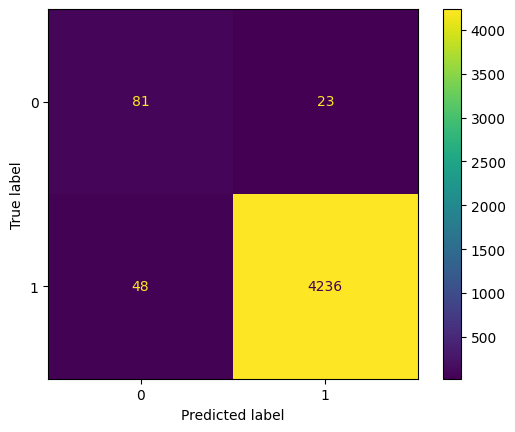

In [23]:
#These two are effectively X_test and y_test
X = reserve_split.iloc[:,1:101]
y = reserve_split.iloc[:,101]

y_pred = hgbt.predict(X)
print("HGBT Default Model Robustness Test")
print(classification_report(y, y_pred),"\n")

print("ROC-AUC Score:", round(roc_auc_score(y, y_pred),4))

#Create confusion matrix
hgbt_cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=hgbt_cm)
disp.plot()
plt.show()

HGBT Tuned Model Robustness Test
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       104
           1       0.99      1.00      0.99      4284

    accuracy                           0.99      4388
   macro avg       0.91      0.87      0.89      4388
weighted avg       0.99      0.99      0.99      4388
 

ROC-AUC Score: 0.8683


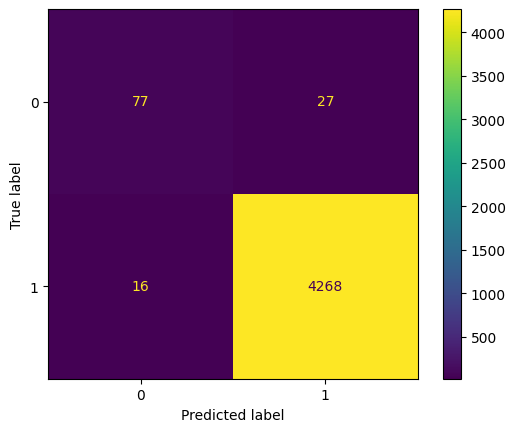

In [24]:
y_pred = hgbt_t.predict(X)
print("HGBT Tuned Model Robustness Test")
print(classification_report(y, y_pred),"\n")

print("ROC-AUC Score:", round(roc_auc_score(y, y_pred),4))

#Create confusion matrix
hgbt_t_cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=hgbt_t_cm)
disp.plot()
plt.show()